# CS 109A/AC 209A/STAT 121A Data Science: Homework 4
**Harvard University**<br>
**Fall 2016**<br>
**Instructors: W. Pan, P. Protopapas, K. Rader**<br>
**Due Date: ** Wednesday, October 5th, 2016 at 11:59pm

Download the `IPython` notebook as well as the data file from Vocareum and complete locally.

To submit your assignment, in Vocareum, upload (using the 'Upload' button on your Jupyter Dashboard) your solution to Vocareum as a single notebook with following file name format:

`last_first_CourseNumber_HW4.ipynb`

where `CourseNumber` is the course in which you're enrolled (CS 109a, Stats 121a, AC 209a). Submit your assignment in Vocareum using the 'Submit' button.

**Avoid editing your file in Vocareum after uploading. If you need to make a change in a solution. Delete your old solution file from Vocareum and upload a new solution. Click submit only ONCE after verifying that you have uploaded the correct file. The assignment will CLOSE after you click the submit button.**

Problems on homework assignments are equally weighted. The Challenge Question is required for AC 209A students and optional for all others. Student who complete the Challenge Problem as optional extra credit will receive +0.5% towards your final grade for each correct solution. 

Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import Lasso as Lasso_Reg
from statsmodels.regression.linear_model import OLS
import sklearn.preprocessing as Preprocessing
import itertools as it
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import scipy as sp
from itertools import combinations
%matplotlib inline

## Problem 0: Basic Information

Fill in your basic information. 

### Part (a): Your name

[Zambalayev, Timur]

### Part (b): Course Number

[CSCI E-109a]

### Part (c): Who did you work with?

[]

**All data sets can be found in the ``datasets`` folder and are in comma separated value (CSV) format**

## Problem 1: Variable selection and regularization

The data set for this problem is provided in ``dataset_1.txt`` and contains 10 predictors and a response variable.

### Part (a): Analyze correlation among predictors
- By visually inspecting the data set, do find that some of the predictors are correlated amongst themselves?


- Compute the cofficient of correlation between each pair of predictors, and visualize the matrix of correlation coefficients using a heat map. Do the predictors fall naturally into groups based on the correlation values?


- If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose? 

**Solution:**

first 10 rows:
[[ 0.95935688  0.95935688  0.95935688  0.34372695  0.52408328  0.53776781
   0.43559824  0.83199927  0.15324701  0.00501577]
 [ 0.6169695   0.6169695   0.6169695   0.28737557  0.51384368  0.49777511
   0.45273244  0.91460929  0.36738984  0.444473  ]
 [ 0.99594053  0.99594053  0.99594053  0.10729412  0.0971065   0.14675084
   0.13641377  0.63592648  0.5352095   0.89945713]
 [ 0.82173155  0.82173155  0.82173155  0.20255776  0.32950426  0.35947128
   0.28145288  0.10626341  0.47932701  0.25627126]
 [ 0.30242269  0.30242269  0.30242269  0.18456376  0.27026295  0.29338515
   0.26386634  0.37862981  0.74024145  0.46858931]
 [ 0.03763453  0.03763453  0.03763453  0.33779404  0.61511664  0.56764403
   0.58995459  0.64830983  0.06158611  0.56185078]
 [ 0.54811654  0.54811654  0.54811654  0.11626237  0.11359164  0.08762936
   0.11138565  0.9282435   0.12174737  0.22162753]
 [ 0.89282671  0.89282671  0.89282671  0.28155135  0.41668107  0.34884158
   0.3518005   0.59422044  0.7122185

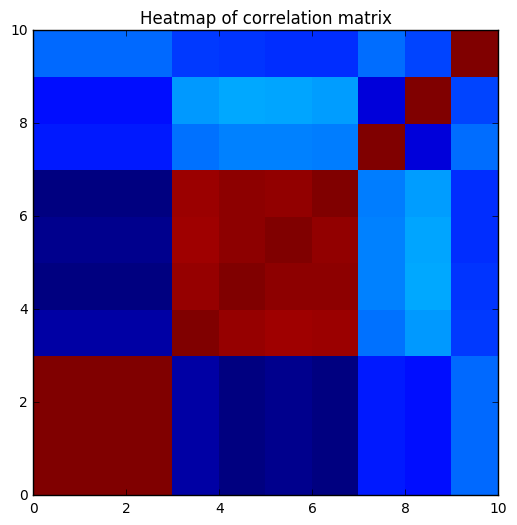

In [2]:
from collections import namedtuple


Dataset_1_Data = namedtuple('Dataset_1_Data', ['x', 'y'])


def load_dataset_1():
    # Load data
    data = np.loadtxt('datasets/dataset_1.txt', delimiter=',', skiprows=1)

    # Split predictors and response
    x = data[:, :-1]
    y = data[:, -1]

    return Dataset_1_Data(x, y)


def heatmap_prob_1a(dataset_1_data):
    x = dataset_1_data.x
    
    print 'first 10 rows:\n', x[:10]

    # Compute matrix of correlation coefficients
    corr_matrix = np.corrcoef(x.T)

    # Display heat map
    _, ax = plt.subplots(1, 1, figsize=(6, 6))

    ax.pcolor(corr_matrix)
    ax.set_title('Heatmap of correlation matrix')

    plt.show()

    
dataset_1_data = load_dataset_1()
heatmap_prob_1a(dataset_1_data)

***By visually inspecting the data set, do you find that some of the predictors are correlated amongst themselves?***

You can notice that the first three predictors have the same value. For other predictors it's difficult to say just by looking at numbers.

By examining the heatmap of the correlation matrix we can say that predictors x1, x2 and x3 are highly correlated to each other, the next four predictors (x4, x5, x6, x7) are also highly correlated to each other.

***If you were asked to select a minimal subset of predictors based on the correlation information in order to build a good regression model, how many predictors will you pick, and which ones will you choose?***

I would choose 5 predictors (one from {x1, x2, x3} group, one from {x4, x5, x6, x7} and the rest - x8, x9, x10). If we have a group of highly correlated to each other predictors, we need only one predictor from that group.

### Part (b): Selecting minimal subset of predictors

- Apply the variable selection methods discussed in class to choose a minimal subset of predictors that yield high prediction accuracy:
    
    - Exhaustive search
    
    - Step-wise forward selection **or** Step-wise backward selection  

&emsp;&nbsp;&nbsp; In each method, use the Bayesian Information Criterion (BIC) to choose the subset size.

- Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?

**Note**: You may use the `statsmodels`'s `OLS` module to fit a linear regression model and evaluate BIC. You may **not** use library functions that implement variable selection.

**Solution:**

In [3]:
import statsmodels.api as sm


def get_regression_results(predictor_subset, x, y):
    # Use only a subset of predictors in the training data
    x_subset = x[:, predictor_subset]

    # Fit and evaluate R^2
    model = sm.OLS(y, sm.add_constant(x_subset))

    return model.fit()


def get_best_k_subset(predictor_set, size_k, x, y):
    # Create all possible subsets of size 'size',
    # using the 'combination' function from the 'itertools' library
    subsets_of_size_k = it.combinations(predictor_set, size_k)

    max_r_squared = -float('inf')  # set some initial small value for max R^2 score
    best_k_subset = []  # best subset of predictors of size k
    best_results = None

    # Iterate over all subsets of our predictor set
    for predictor_subset in subsets_of_size_k:
        results = get_regression_results(predictor_subset, x, y)
        r_squared = results.rsquared

        # Update max R^2 and best predictor subset of size k
        # If current predictor subset has a higher R^2 score than that of the best subset
        # we've found so far, remember the current predictor subset as the best!
        if r_squared > max_r_squared:
            max_r_squared = r_squared
            best_k_subset = predictor_subset
            best_results = results

    return best_k_subset, best_results


def get_results_stats(results):
    return 'bic: %.3f, R^2: %.3f' % (results.bic, results.rsquared)


def exhaustive_search_prob_1b(dataset_1_data):
    x = dataset_1_data.x
    y = dataset_1_data.y

    # Best Subset Selection
    min_bic = float('inf')  # set some initial large value for min BIC score
    best_subset = []  # best subset of predictors
    best_results = None

    num_predictors = x.shape[1]

    # Create all possible subsets of the set of <num_predictors> predictors
    predictor_set = range(num_predictors)  # e.g. predictor set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

    # Repeat for every possible size of subset
    for size_k in range(1, num_predictors + 1):
        k_subset, results = get_best_k_subset(predictor_set, size_k, x, y)

        bic = results.bic

        # Update minimum BIC and best predictor subset
        # If current predictor has a lower BIC score than that of the best subset
        # we've found so far, remember the current predictor as the best!
        if bic < min_bic:
            min_bic = bic
            best_subset = k_subset
            best_results = results

        print 'k: %2d, %s, subset: %s, ' % (size_k, get_results_stats(results), str(k_subset))

    print 'Best subset by exhaustive search: %s, %s' % (str(best_subset), get_results_stats(best_results))

    
exhaustive_search_prob_1b(dataset_1_data)

k:  1, bic: -36.720, R^2: 0.369, subset: (8,), 
k:  2, bic: -61.732, R^2: 0.531, subset: (8, 9), 
k:  3, bic: -65.729, R^2: 0.570, subset: (5, 8, 9), 
k:  4, bic: -71.008, R^2: 0.610, subset: (5, 7, 8, 9), 
k:  5, bic: -72.366, R^2: 0.633, subset: (0, 5, 7, 8, 9), 
k:  6, bic: -70.355, R^2: 0.642, subset: (0, 3, 5, 7, 8, 9), 
k:  7, bic: -66.159, R^2: 0.644, subset: (0, 3, 5, 6, 7, 8, 9), 
k:  8, bic: -61.803, R^2: 0.645, subset: (0, 3, 4, 5, 6, 7, 8, 9), 
k:  9, bic: -61.803, R^2: 0.645, subset: (0, 1, 3, 4, 5, 6, 7, 8, 9), 
k: 10, bic: -61.803, R^2: 0.645, subset: (0, 1, 2, 3, 4, 5, 6, 7, 8, 9), 
Best subset by exhaustive search: (0, 5, 7, 8, 9), bic: -72.366, R^2: 0.633


In [4]:
def find_best_predictor_to_add(current_predictors, remaining_predictors, x, y):
    max_r_squared = -float('inf')  # set some initial small value for max R^2
    best_predictor = -1  # set some throwaway initial number for the best predictor to add
    best_results = None

    # Iterate over all remaining predictors to find best predictor to add
    for i in remaining_predictors:
        # Make copy of current set of predictors
        predictor_subset = current_predictors[:]
        # Add predictor 'i'
        predictor_subset.append(i)

        results = get_regression_results(predictor_subset, x, y)
        r_squared = results.rsquared

        # Check if we get a higher R^2 value than than current max R^2, if so, update
        if r_squared > max_r_squared:
            max_r_squared = r_squared
            best_predictor = i
            best_results = results

    return best_predictor, best_results


def stepwise_forward_selection_prob_1b(dataset_1_data):
    x = dataset_1_data.x
    y = dataset_1_data.y

    # Step-wise Forward Selection
    d = x.shape[1]  # total no. of predictors

    # Keep track of current set of chosen predictors, and the remaining set of predictors
    current_predictors = []
    remaining_predictors = range(d)

    # Set some initial large value for min BIC score for all possible subsets
    min_bic = float('inf')
    results = None

    # Keep track of the best subset of predictors
    best_subset = []

    # Iterate over all possible subset sizes, 0 predictors to d predictors
    for size in range(d):
        predictor, results = find_best_predictor_to_add(current_predictors, remaining_predictors, x, y)

        # Remove best predictor from remaining list, and add best predictor to current list
        remaining_predictors.remove(predictor)
        current_predictors.append(predictor)

        print 'size: %d, %s, subset: %s, ' % (size, get_results_stats(results), str(current_predictors))

        # Check if BIC for with the predictor we just added is lower than
        # the global minimum across all subset of predictors
        if results.bic < min_bic:
            best_subset = current_predictors[:]
            min_bic = results.bic
            results = results

    print 'Best step-wise forward subset selection: %s, %s' % (str(sorted(best_subset)), get_results_stats(results))

    
stepwise_forward_selection_prob_1b(dataset_1_data)

size: 0, bic: -36.720, R^2: 0.369, subset: [8], 
size: 1, bic: -61.732, R^2: 0.531, subset: [8, 9], 
size: 2, bic: -65.729, R^2: 0.570, subset: [8, 9, 5], 
size: 3, bic: -71.008, R^2: 0.610, subset: [8, 9, 5, 7], 
size: 4, bic: -72.366, R^2: 0.633, subset: [8, 9, 5, 7, 0], 
size: 5, bic: -70.355, R^2: 0.642, subset: [8, 9, 5, 7, 0, 3], 
size: 6, bic: -66.159, R^2: 0.644, subset: [8, 9, 5, 7, 0, 3, 6], 
size: 7, bic: -61.803, R^2: 0.645, subset: [8, 9, 5, 7, 0, 3, 6, 4], 
size: 8, bic: -61.803, R^2: 0.645, subset: [8, 9, 5, 7, 0, 3, 6, 4, 1], 
size: 9, bic: -61.803, R^2: 0.645, subset: [8, 9, 5, 7, 0, 3, 6, 4, 1, 2], 
Best step-wise forward subset selection: [0, 5, 7, 8, 9], bic: -61.803, R^2: 0.645


***Do the chosen subsets match the ones you picked using the correlation matrix you had visualized in Part (a)?***

Both methods returned the same set of predictors (x1, x6, x8, x9, x10) and they match the criteria set in part (a), that is x1 is one predictor from the first group of predictors correlated to each other (x1, x2, x3) and x6 is from the second group (x4, x5, x6, x7).

### Part (c): Apply Lasso and Ridge regression

- Apply Lasso regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Apply Ridge regression with regularization parameter $\lambda = 0.01$ and fit a regression model.

    - Is there a difference between the model parameters you obtain different and those obtained from Lasso regression? If so, explain why.

    - Identify the predictors that are assigned non-zero coefficients. Do these correspond to  the correlation matrix in Part (a)?


- Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.

**Note**: You may use the `statsmodels` or `sklearn` to perform Lasso and Ridge regression.

**Solution:**

In [5]:
def lasso_regression_prob_1c(dataset_1_data):
    x = dataset_1_data.x
    y = dataset_1_data.y

    # Lasso regression
    reg = Lasso_Reg(alpha=0.01)
    reg.fit(x, y)
    coefficients = reg.coef_

    print 'Lasso:'
    print 'Coefficients:', coefficients
    print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]


lasso_regression_prob_1c(dataset_1_data)

Lasso:
Coefficients: [ 0.02717417  0.          0.         -0.         -0.02532806 -0.         -0.
  0.04397321 -0.40612185 -0.22260474]
Predictors with non-zero coefficients: [0, 4, 7, 8, 9]


The subset of predictors chosen by Lasso agrees with the correlation matrix we visualize in Part (a). That is, the best predictor subset contains five predictors, with **one predictor from each group of correlated predictors**.

In [6]:
def ridge_regression_prob_1c(dataset_1_data):
    x = dataset_1_data.x
    y = dataset_1_data.y

    # Ridge regression: Fit and evaluate
    reg = Ridge_Reg(alpha=0.01)
    reg.fit(x, y)
    coefficients = reg.coef_

    print 'Ridge:'
    print 'Coefficients:', coefficients
    print 'Predictors with non-zero coefficients:', [i for i, item in enumerate(coefficients) if abs(item) > 0]


ridge_regression_prob_1c(dataset_1_data)

Ridge:
Coefficients: [ 0.04353543  0.04353543  0.04353543  0.55217415 -0.19706852 -0.61421737
  0.30484213  0.18742866 -0.50083242 -0.35908145]
Predictors with non-zero coefficients: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


***Is there a difference between the model parameters obtained from Ridge regression and those obtained from Lasso regression? If so, explain why.***

The ridge regression model coefficients are all non-zero, whereas some of the coefficients obtained from the lasso regression equal zero. The ridge regression coefficients are getting closer to zero as the tuning parameter gets larger. In contrast lasso regression model coefficients can become zero as the tuning/regularization parameter gets larger.

***Identify the predictors that are assigned non-zero coefficients. Do these correspond to the correlation matrix in Part (a)?***

All predictors have non-zero coefficients. The ridge regression doesn't do variable selection.

***Is there anything peculiar that you observe about the coefficients Ridge regression assigns to the first three predictors? Do you observe the same with Lasso regression? Give an explanation for your observation.***

For ridge regression the first three predictors have exactly the same coefficients. For the lasso regression only of those coefficients are non-zero. This is because the lasso regression can do variable selection and ridge regression doesn't. It only makes sure that the coefficients are within the limits set by the tuning parameter.

## Problem 2: Cross-validation and Bootstrapping
In this problem, you will work with an expanded version of the automobile pricing data set you analyzed in Homework 3. The data set is contained ``dataset_2.txt``, with 26 attribues (i.e. predictors) for each automobile and corresponding prices. 

### Part(a): Encode categorical attributes and fill missing values
Identify the categorical attributes in the data. Replace their values with the one-hot binary encoding. You may do this using the `get_dummies()` function in `pandas`. If you do this task correctly, you should get a total of 69 predictors after the encoding.


**Solution:**

In [9]:
Dataset_2_Data = namedtuple('Dataset_2_Data', ['train', 'test'])

XY_Data = namedtuple('XY_Data', ['x', 'y'])


def split(df, split_index):
    train = df[:split_index]
    test = df[split_index:]
    return train, test


def is_categorical(column):
    return column.dtype == object or len(column.unique()) < 8


def encode_categorical_variables_prob_2a():
    df = pd.read_csv('datasets/dataset_2.txt')

    y = df['price']
    x_df = df.drop('price', axis=1)

    expanded_x_df = x_df.copy()
    for column_name in df.columns:
        column = df[column_name]
        if is_categorical(column):
            dummies_df = pd.get_dummies(column, prefix=column_name)

            expanded_x_df = expanded_x_df.drop(column_name, axis=1)
            expanded_x_df = pd.concat([expanded_x_df, dummies_df], axis=1)

    split_index = len(expanded_x_df) // 4

    x_train, x_test = split(expanded_x_df, split_index)
    y_train, y_test = split(y, split_index)

    train = XY_Data(x_train, y_train)
    test = XY_Data(x_test, y_test)

    return Dataset_2_Data(train, test)


def print_expanded_df_prob_2a(dataset_2_data):
    x = dataset_2_data.train.x

    print '%d predictors:' % len(x.columns)
    print x.columns

    
dataset_2_data = encode_categorical_variables_prob_2a()
print_expanded_df_prob_2a(dataset_2_data)

69 predictors:
Index([u'horsepower', u'highway-mpg', u'normalized-losses', u'wheel-base',
       u'length', u'width', u'height', u'curb-weight', u'engine-size', u'bore',
       u'stroke', u'compression-ratio', u'peak-rpm', u'city-mpg',
       u'symboling_-2.0', u'symboling_0.0', u'symboling_1.0',
       u'symboling_1.09604519774', u'symboling_2.0', u'symboling_3.0',
       u'make_audi', u'make_bmw', u'make_chevrolet', u'make_dodge',
       u'make_honda', u'make_mazda', u'make_mercedes-benz', u'make_mercury',
       u'make_mitsubishi', u'make_nissan', u'make_peugot', u'make_plymouth',
       u'make_porsche', u'make_renault', u'make_saab', u'make_subaru',
       u'make_toyota', u'make_volkswagen', u'make_volvo', u'fuel-type_diesel',
       u'fuel-type_gas', u'aspiration_std', u'aspiration_turbo',
       u'num-of-doors_four', u'num-of-doors_two', u'body-style_convertible',
       u'body-style_hardtop', u'body-style_hatchback', u'body-style_sedan',
       u'body-style_wagon', u'drive-wheel

### Part (b): Apply regular linear regression
- Split the data set into train and test sets, with the first 25% of the data for training and the remaining for testing.  


- Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?


- You had seen in class that the R^2 value of a least-squares fit to a data set would lie between 0 and 1. Is this true for the test R^2 values reported above? If not, give a reason for why this is the case.


- Is there a need for regularization while fitting a linear model to this data set?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits.

**Solution:**

In [12]:
def score(regression, train, test):
    train_score = regression.score(*train)
    test_score = regression.score(*test)
    return train_score, test_score


def linear_regression_prob_2b(dataset_2_data):
    train = dataset_2_data.train
    test = dataset_2_data.test

    print 'x train shape: %s' % str(train.x.shape)

    linear_regression = Lin_Reg()
    linear_regression.fit(*train)

    train_score, test_score = score(linear_regression, train, test)

    print 'train R^2: %.3f, test R^2: %.3f' % (train_score, test_score)

    
linear_regression_prob_2b(dataset_2_data)

x train shape: (51, 69)
train R^2: 1.000, test R^2: -5.975


***Use regular linear regression to fit a model to the training set and evaluate the R^2 score of the fitted model on both the training and test sets. What do you observe about these values?***

We have a perfect training R^2 score (1.0) because the number of observations (n=51) is less than the number of predictors (k=69). And because of high dimensionality (k>n) the test score is quite low (-6.0).

***Is there a need for regularization while fitting a linear model to this data set?***

No. We need to do this for the ridge regression.

### Part (c): Apply Ridge regression

- Apply Ridge regression on the training set for different values of the regularization parameter $\lambda$ in the range $\{10^{-7}, 10^{-6}, \ldots, 10^7\}$. Evaluate the R^2 score for the models you obtain on both the train and test sets. Plot both values as a function of $\lambda$. 


- Explain the relationship between the regularization parameter and the training and test R^2 scores.


- How does the best test R^2 value obtained using Ridge regression compare with that of plain linear regression? Explain.

**Note**: You may use the `statsmodels` or `sklearn` to fit a ridge regression model and evaluate the fits.

**Solution:**

alpha: 1e-07, train R^2: 1.000, test R^2: -6.586
alpha: 1e-06, train R^2: 1.000, test R^2: -2.880
alpha: 1e-05, train R^2: 1.000, test R^2:  0.273
alpha: 1e-04, train R^2: 1.000, test R^2:  0.718
alpha: 1e-03, train R^2: 0.999, test R^2:  0.881
alpha: 1e-02, train R^2: 0.997, test R^2:  0.931
alpha: 1e-01, train R^2: 0.992, test R^2:  0.935
alpha: 1e+00, train R^2: 0.964, test R^2:  0.914
alpha: 1e+01, train R^2: 0.685, test R^2:  0.638
alpha: 1e+02, train R^2: 0.160, test R^2:  0.129
alpha: 1e+03, train R^2: 0.018, test R^2: -0.005
alpha: 1e+04, train R^2: 0.002, test R^2: -0.021
alpha: 1e+05, train R^2: 0.000, test R^2: -0.022
alpha: 1e+06, train R^2: 0.000, test R^2: -0.022
alpha: 1e+07, train R^2: 0.000, test R^2: -0.022


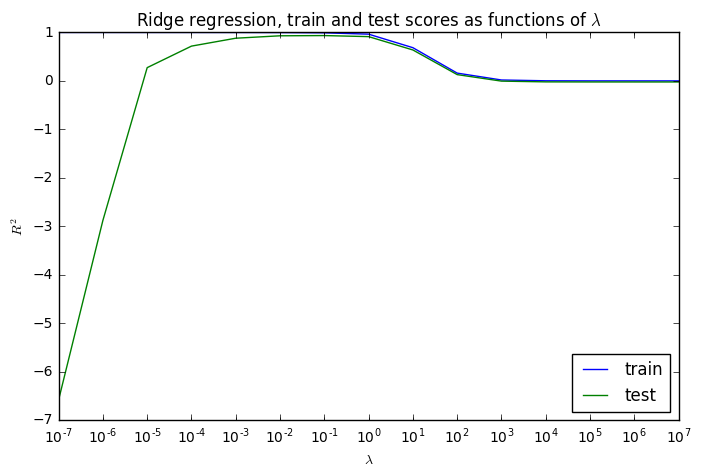

In [13]:
def ridge_regression_prob_2c(dataset_2_data):
    train = dataset_2_data.train
    test = dataset_2_data.test

    alpha_list = []
    train_score_list = []
    test_score_list = []

    for exponent in range(-7, 8):
        alpha = 10 ** exponent

        ridge_regression = Ridge_Reg(alpha=alpha, normalize=True)
        ridge_regression.fit(*train)
        train_score, test_score = score(ridge_regression, train, test)

        print 'alpha: %.0e, train R^2: %.3f, test R^2: % .3f' % (alpha, train_score, test_score)

        train_score_list.append(train_score)
        test_score_list.append(test_score)
        alpha_list.append(alpha)

    _, ax = plt.subplots(1, 1, figsize=(8, 5))

    ax.plot(alpha_list, train_score_list, label='train')
    ax.plot(alpha_list, test_score_list, label='test')

    ax.set_xscale('log')
    ax.set_xlabel('$\lambda$')
    ax.set_ylabel('$R^2$')
    ax.set_title('Ridge regression, train and test scores as functions of $\lambda$')

    ax.legend(loc='lower right')

    plt.show()

    
ridge_regression_prob_2c(dataset_2_data)

### Part (d): Tune regularization parameter using cross-validation and bootstrapping
-  Evaluate the performance of the Ridge regression for different regularization parameters $\lambda$ using 5-fold cross validation **or** bootstrapping on the training set. 

    - Plot the cross-validation (CV) or bootstrapping R^2 score as a function of $\lambda$. 
    
    - How closely does the CV score or bootstrapping score match the R^2 score on the test set? Does the model with lowest CV score or bootstrapping score correspond to the one with maximum R^2 on the test set?
    
    - Does the model chosen by CV or bootstrapping perform better than plain linear regression?

**Note**: You may use the `statsmodels` or `sklearn` to fit a linear regression model and evaluate the fits. You may also use `kFold` from `sklearn.cross_validation`. 

**Solution:**

## Problem 3: Ridge regression *via* ordinary least-squares regression

We present an approach to implement Ridge regression using oridinary least-squares regression. Given a matrix of responses $\mathbf{X} \in \mathbb{R}^{n\times p}$ and response vector $\mathbf{y} \in \mathbb{R}^{n}$, one can implement Ridge regression with regularization parameter $\lambda$ as follows:

- Augment the matrix of predictors $\mathbf{X}$ with $p$ new rows containing the scaled identity matrix $\sqrt{\lambda}\mathbf{I} \in \mathbb{R}^{p \times p}$, i.e.
$$\overline{\mathbf{X}} \,=\, 
\begin{bmatrix}
X_{11} & \ldots & X_{1p}\\
\vdots & \ddots & \vdots\\
X_{n1} & \ldots & X_{np}\\
\sqrt{\lambda} & \ldots & 0\\
\vdots & \ddots & \vdots\\
0 & \ldots & \sqrt{\lambda}
\end{bmatrix}
\,\in\,
\mathbb{R}^{(n+p)\times p}
.
$$


- Augment the response vector $\mathbf{y}$ with a column of $p$ zeros, i.e.
$$
\overline{\mathbf{y}} \,=\, 
\begin{bmatrix}
y_{1}\\
\vdots\\
y_{n}\\
0\\
\vdots\\
0
\end{bmatrix}
\,\in\,
\mathbb{R}^{n+p}.
$$


- Apply ordinary least-squares regression on the augmented data set $(\overline{\mathbf{X}}, \overline{\mathbf{y}})$.

### Part (a): Show the proposed approach implements Ridge regression
Show that the approach proposed above implements Ridge regression with parameter $\lambda$.

### Part (b): Debug our implementation of ridge regression
You're a grader for CS109A, the following is an implemention of Ridge regression (via the above approach) submitted by a student. The dataset is ``dataset_3.txt``. The regression model is fitted to a training set, and the R^2 scores of the fitted model on the training and test sets are plotted as a function of the regularization parameter. Grade this solution according to the following rubric (each category is equally weighted): 

- correctness

- interpretation (if applicable)

- code/algorithm design

- presentation

In addition to providing an holistic grade (between 0 to 5), provide a corrected version of this code that is submission quality.

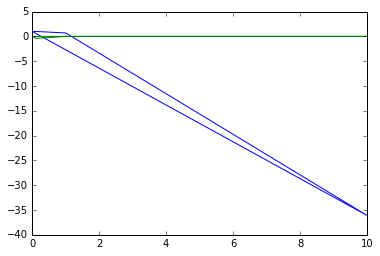

In [91]:
# Fit
def ridge(x_train, y_train, reg_param):
    n=np.shape(x_train)[0]
    x_train=np.concatenate((x_train,reg_param*np.identity(n)),axis=1)
    y_train_=np.zeros((n+np.shape(x_train)[1],1))
    for c in range(n):
        y_train_[c]= y_train[c]
    import sklearn
    model = sklearn.linear_model.LinearRegression()
    model.fit(x_train,y_train.reshape(-1,1))
    return model

# Score
def score(m,x_test,y_test, reg_param):
    n=np.shape(x_train)[0]
    x_test=np.concatenate((x_test,reg_param*np.identity(n)),axis=1)
    y_test_=np.zeros((n+np.shape(x_test)[1],1))
    for c in range(n):
        y_test_[c]= y_test[c]
    return m.score(x_test,y_test.reshape(-1,1))

# Load
data = np.loadtxt('datasets/dataset_3.txt', delimiter=',')
n = data.shape[0]
n = int(np.round(n*0.5))
x_train = data[0:n,0:100]
y_train = data[0:n,100]
x_test = data[n:2*n,0:100]
y_test = data[n:2*n,100]

# Params
a=np.zeros(5)
for i in range(-2,2):
    a[i+2]=10**i

# Iterate
rstr =np.zeros(5)
rsts =np.zeros(5)
for j in range(0,5):    
    m =ridge(x_train,y_train,a[i])
    rstr[j]=score(m,x_train,y_train,a[j])
    rsts[i]=score(m,x_test,y_test,a[i])

# Plot
plt.plot(a,rstr)
plt.plot(a,rsts)

## Challenge Problem: Predicting Outcome of a Fund-raising Campaign
You are provided a data set containing details of mail sent to 95,412 potential donors for a fund-raising campaign of a not-for-profit organization. This data set also contains the amount donated by each donor. The task is to build a model that can estimate the amount that a donor would donate using his/her attributes. The data is contained in the file `dataset_4.txt`. Each row contains 376 attributes for a donor, followed by the donation amount.

**Note**: For additional information about the attributes used, please look up the file `dataset_4_description.txt`. This files also contains details of attributes that have been omitted from the data set.

### Part (a): Fit regression model
Build a suitable model to predict the donation amount. How good is your model? 


### Part (b): Evaluate the total profit of the fitted model
Suppose you are told that the cost of mailing the donor is \$7. Use your model to maximize profit. Implement, explain and rigorously justify your strategy. How does your strategry compare with blanket mailing everyone.

### Part (c): Further Discussion
In hindsight, thoroughly discuss the appropriatenes of using a regression model for this dataset (you must at least address the suitability with respect to profit maximization and model assumptions). Rigorously justify your reasoning. 